## Homemade Neural Network Evaluating a Real Estate Dataset

This project was undertaken as part of a neural networks course, with the primary goal of conducting a thorough exploration, cleansing, and preparation of the data, followed by the development and evaluation of a customized neural network.

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('housing_sold_in_30.csv')

In [3]:
# Set the max_columns option to None
pd.set_option('display.max_columns', None)

In [4]:
# Inspect data
df.head()

,sold_in_30,asking_price,bedrooms,bathrooms,heating,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated
0,1,221900.0,3,1.00,electric,1180,5650,1.0,poor,average,7,1180,1955,0.0
1,0,538000.0,3,2.25,gas,2570,7242,2.0,poor,average,7,2170,1951,1991.0
2,0,510000.0,3,2.00,gas,1680,8080,1.0,poor,average,8,1680,1987,0.0
3,1,291850.0,3,1.50,gas,1060,9711,1.0,poor,average,7,1060,1963,0.0
4,1,468000.0,2,1.00,gas,1160,6000,1.0,poor,good,7,860,1942,0.0


In [5]:
# Checking for null values
df.isnull().sum()

sold_in_30      0
asking_price    0
bedrooms        0
bathrooms       0
heating         0
sqft_living     0
sqft_lot        0
floors          0
view            0
condition       0
grade           0
sqft_above      0
yr_built        0
yr_renovated    0
dtype: int64

In [6]:
# Check for duplicates
df.duplicated().any()

False

## Exploratory Data Analysis

In [7]:
# Examining distributions of the data
desc_df = df.describe().T
desc_df_styled = desc_df.style.set_table_styles([{'selector': 'th', 
                                                   'props': [('background-color', 'lightsteelblue'), 
                                                             ('color', 'white'), 
                                                             ('border-color', 'black'),
                                                             ('border-style', 'solid'),
                                                             ('border-width', '1px')]}, 
                                                 {'selector': 'td', 
                                                  'props': [('border-color', 'black'),
                                                            ('border-style', 'solid'),
                                                            ('border-width', '1px')]},
                                                 {'selector': 'th:first-child', 
                                                  'props': [('border-left-width', '0px')]}])

# Highlight the bedrooms and sqft_lot rows
desc_df_styled = desc_df_styled.apply(lambda x: ['background-color: mistyrose' 
                                                 if x.name in ['bedrooms', 'sqft_lot'] else '' for i in x], axis=1)

# Display the styled DataFrame
display(desc_df_styled)

,count,mean,std,min,25%,50%,75%,max
sold_in_30,11592.000000,0.609731,0.487832,0.000000,0.000000,1.000000,1.000000,1.000000
asking_price,11592.000000,539072.125949,361000.939117,78000.000000,320000.000000,450000.000000,641275.000000,6890000.000000
bedrooms,11592.000000,3.371722,0.950834,1.000000,3.000000,3.000000,4.000000,33.000000
bathrooms,11592.000000,2.114540,0.769779,0.500000,1.750000,2.250000,2.500000,7.750000
sqft_living,11592.000000,2076.447119,914.308170,370.000000,1420.000000,1920.000000,2540.000000,9890.000000
sqft_lot,11592.000000,15439.659765,44631.548046,572.000000,5040.000000,7601.000000,10634.000000,1651359.000000
floors,11592.000000,1.491071,0.541029,1.000000,1.000000,1.500000,2.000000,3.500000
grade,11592.000000,7.653382,1.175090,3.000000,7.000000,7.000000,8.000000,13.000000
sqft_above,11592.000000,1780.424258,822.283662,370.000000,1190.000000,1560.000000,2190.000000,8860.000000
yr_built,11592.000000,1971.067460,29.351395,1900.000000,1952.000000,1975.000000,1997.000000,2015.000000


As you can see from this chart, there are some potential outliers in the dataset that may warrant further investigation. For instance, the mean number of bedrooms is 3.37, yet there appears to be at least one property in the dataset that has 33 bedrooms. Similarly, while the mean sqft_lot value is 15,298, there is a maximum value in the dataset that exceeds 1,000,000 square feet.

Outliers can significantly affect the accuracy of the model and distort our understanding of the data. Therefore, it is important to investigate them further to determine whether they are valid data points or erroneous values that need to be corrected or removed.

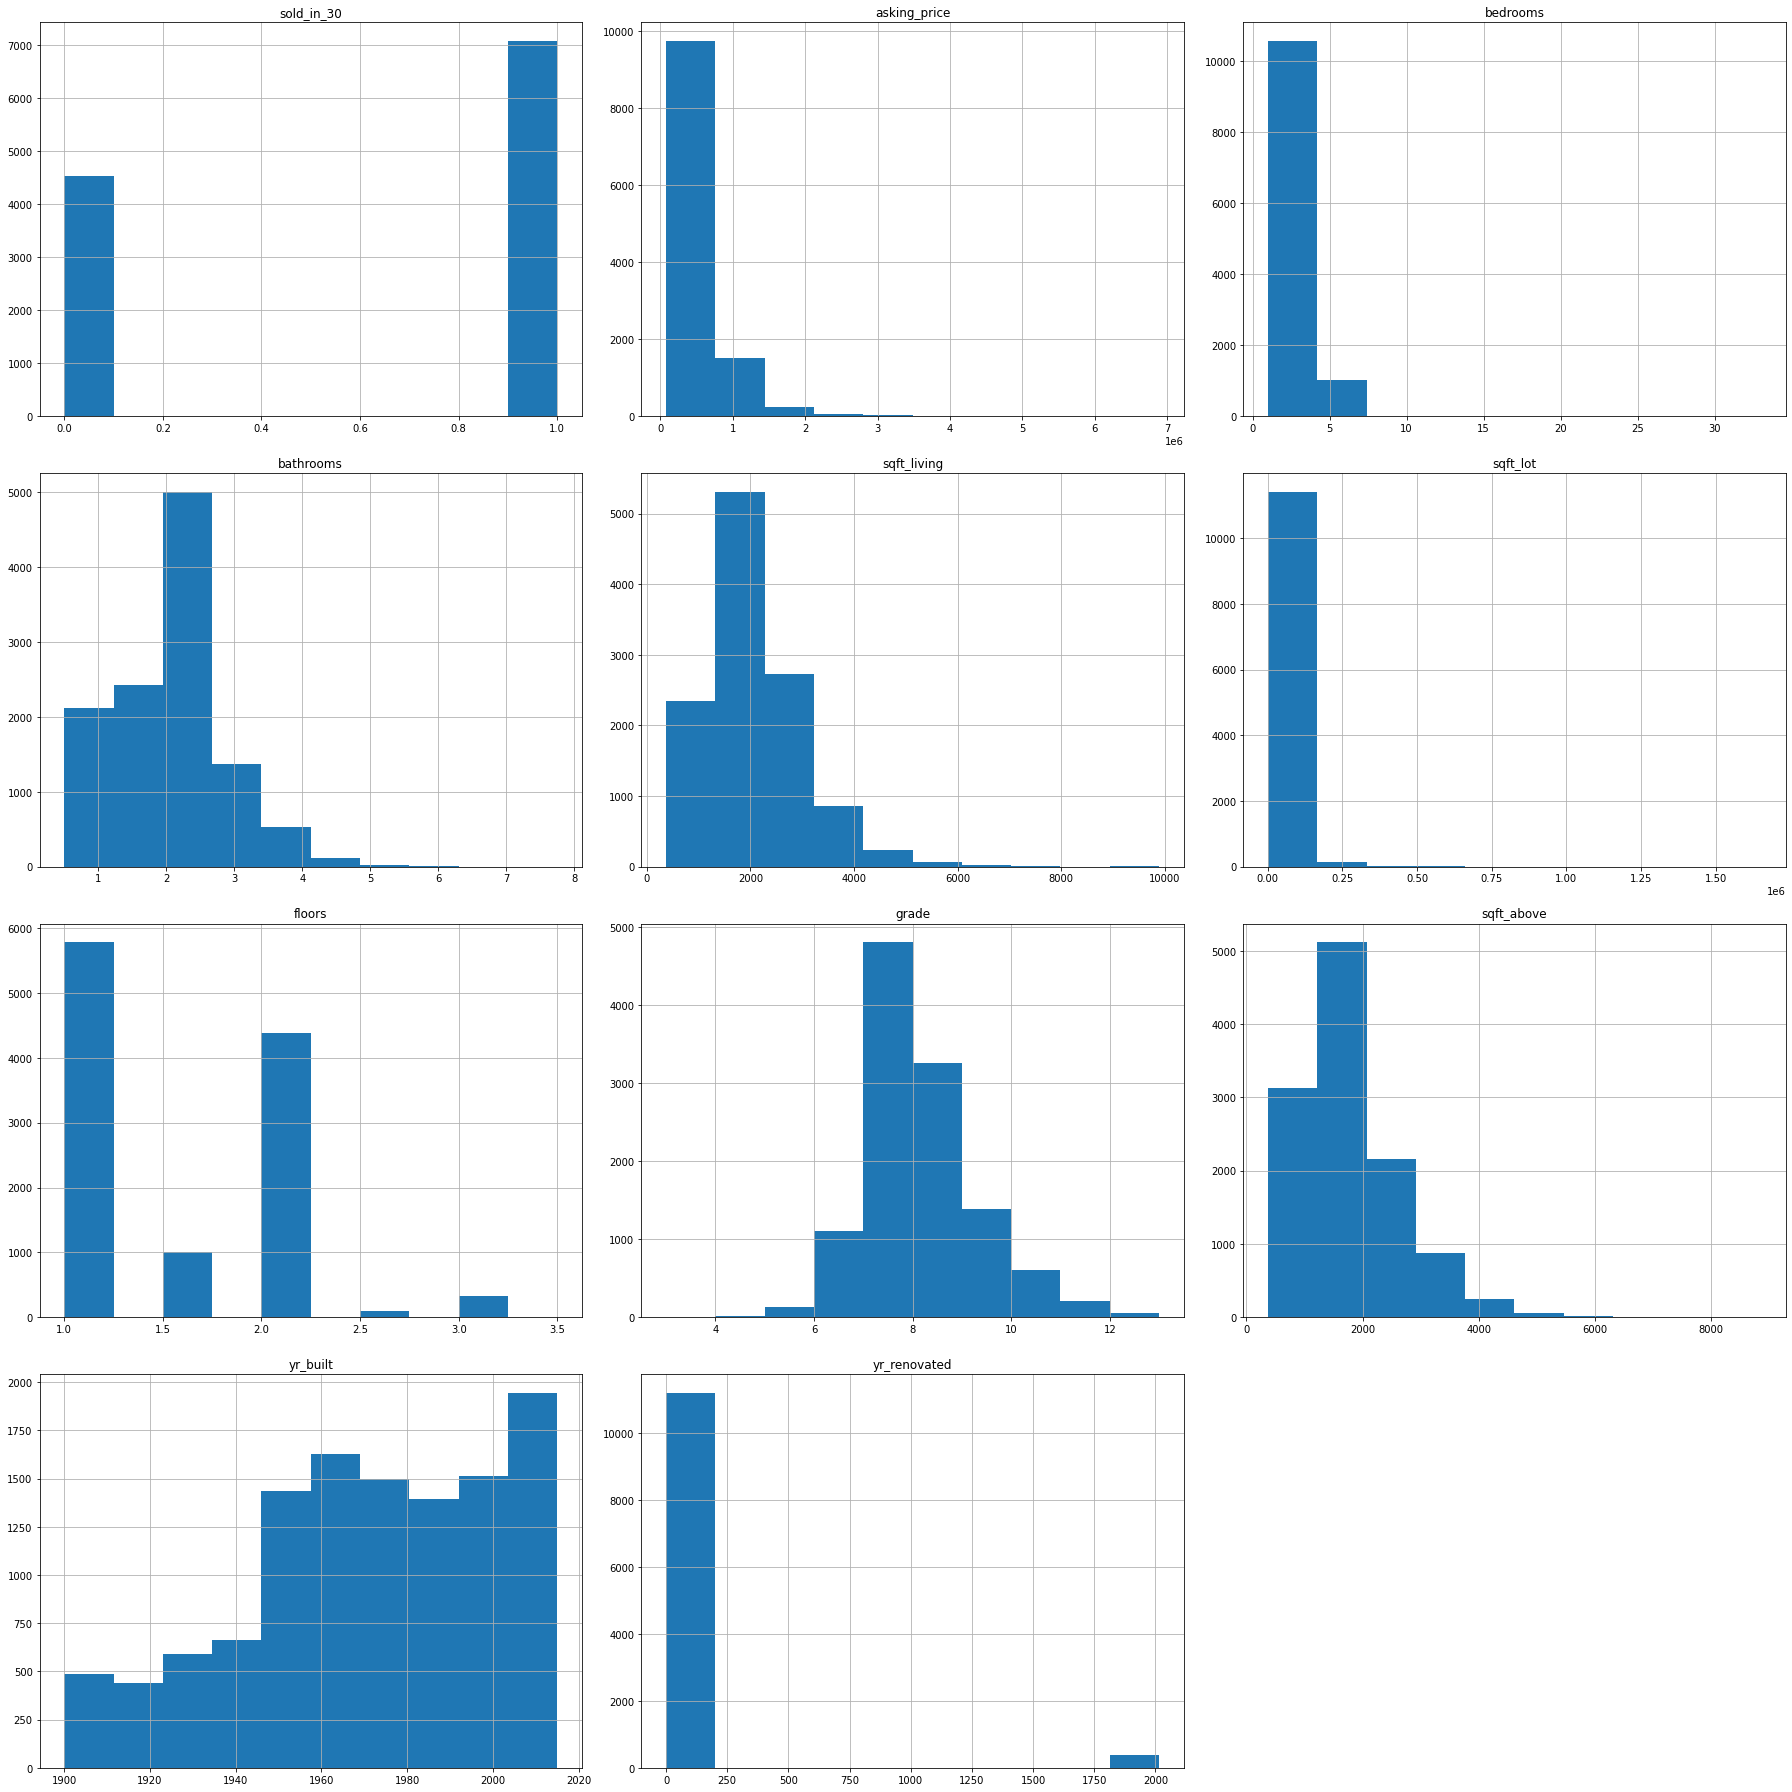

In [8]:
# Examine distributions of each variable
df.hist(figsize=(25,25), bins=10)
plt.tight_layout()

Histograms can provide insights into the distribution of data across each feature. However, they may not be effective in displaying outliers. In contrast, boxplots are useful for identifying outliers, as demonstrated below:

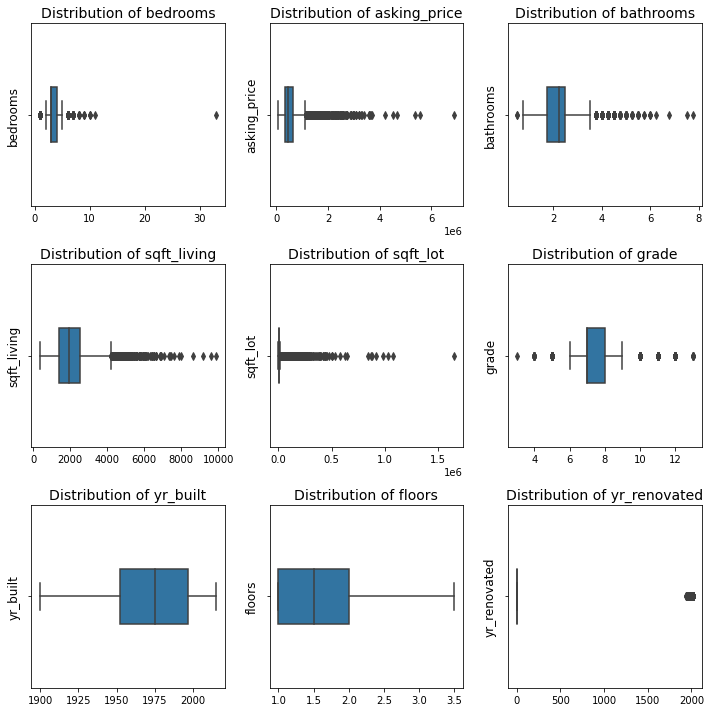

In [9]:
# Define the columns to create box plots for
columns_to_plot = ['bedrooms', 'asking_price', 'bathrooms', 'sqft_living',
                  'sqft_lot','grade','yr_built','floors','yr_renovated']

# Create a grid of subplots for the box plots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

# Loop over each column and create a box plot in a separate subplot
for ax, col in zip(axes.flatten(), columns_to_plot):
    sns.boxplot(x=df[col], ax=ax, width=0.3)
    ax.set_xlabel("")
    ax.set_ylabel(col, fontsize=12)
    ax.set_title(f"Distribution of {col}", fontsize=14)

# Adjust the layout of the subplots
plt.tight_layout()

# Display the box plots
plt.show()

From the boxplots, it's clear that there are some outliers present in the data. To ensure that the model is not adversely affected by the outliers, various methods can be employed to deal with them. Let's take a closer look at some of the obvious outliers.

In [10]:
# Inspect bedrooms outlier
df[df['bedrooms'] > 30]

,sold_in_30,asking_price,bedrooms,bathrooms,heating,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated
8532,0,640000.0,33,1.75,oil,1620,6000,1.0,poor,very good,7,1040,1947,0.0


This looks suspicious as there are 33 bedrooms and only 1620 sq. feet of living space. This is likely erroneous data.

In [11]:
# Inspect sqft_lot outlier
df[df['sqft_lot'] > 1500000]

,sold_in_30,asking_price,bedrooms,bathrooms,heating,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated
925,0,700000.0,4,1.0,electric,1300,1651359,1.0,good,good,6,1300,1920,0.0


This is likely bad data but it is plausible that it could be a huge lot of land with a tiny house on it.

In [12]:
# Inspect asking_price outlier
df[df['asking_price'] > 6000000]

,sold_in_30,asking_price,bedrooms,bathrooms,heating,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated
4957,0,6890000.0,6,7.75,oil,9890,31374,2.0,very good,average,13,8860,2001,0.0


This one looks legitimate as it has a lot of square feet/bedrooms/bathrooms.

Regardless, for this particular run, I decided to remove the rows with the maximum value from those three columns (bedrooms, asking_price, and sqft_lot) as they each have a single extreme outlier.

After removing these outliers, the data will be split into training and testing sets, and the StandardScaler will be used to scale the data. While scaling will help to reduce the impact of other outliers, it's worth noting that the presence of outliers may still influence the scaling.

In [13]:
# Create a list of column names
cols_to_remove_max = ['bedrooms', 'asking_price', 'sqft_lot']

# Loop over the columns and remove the max value
for col in cols_to_remove_max:
    max_val = df[col].max()
    df = df[df[col] != max_val]

Let's examine the relationships bewteen some of the features and the asking price next...

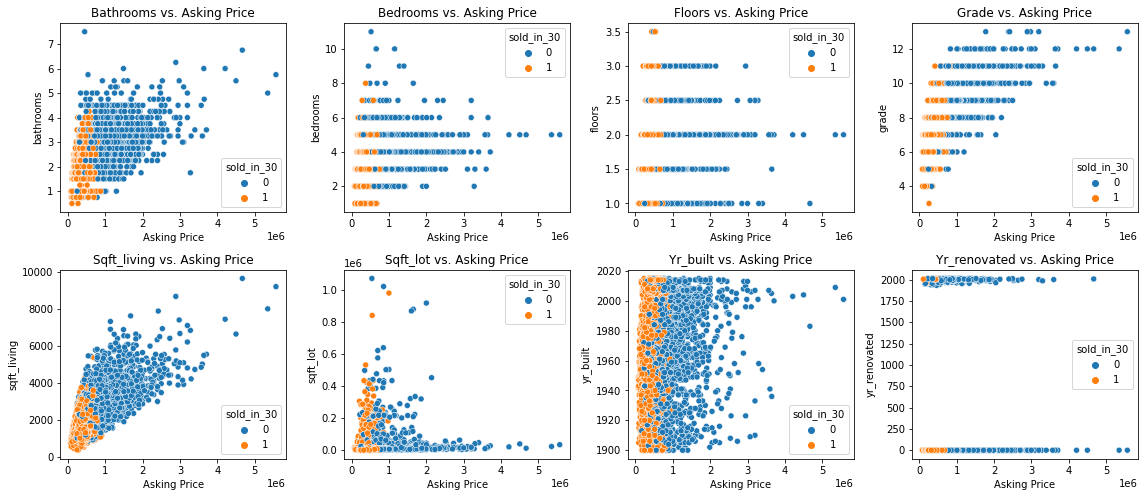

In [14]:
# Define the columns to plot
columns = ['bathrooms', 'bedrooms', 'floors', 'grade', 'sqft_living', 'sqft_lot', 'yr_built', 'yr_renovated']

# Create a figure with a 2x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 10))

# Flatten the axes object to simplify indexing
axes = axes.flatten()

# Iterate over each column and create a scatter plot
for i, column in enumerate(columns):
    ax = axes[i]
    sns.scatterplot(data=df, x='asking_price', y=column, hue='sold_in_30', ax=ax)
    ax.set_xlabel('Asking Price')
    ax.set_ylabel(column)
    ax.set_title(f'{column.capitalize()} vs. Asking Price')

# Hide the unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Adjust the layout of the subplots
fig.tight_layout()


As suspected, there appears to be a significant relationship between two pairs of variables in the dataset. Specifically, there is a strong positive correlation between the sqft_living and asking_price variables, suggesting that larger living spaces tend to command higher prices. Similarly, there is also a strong positive correlation between the bathrooms and asking_price variables, indicating that properties with more bathrooms tend to have higher asking prices.

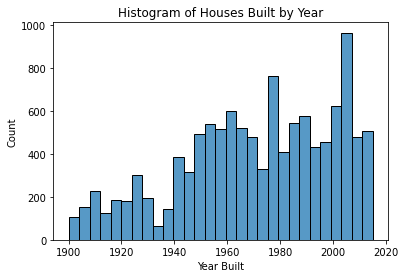

In [15]:
# Create a histogram of the year built
sns.histplot(df, x='yr_built')

# Set the title and axis labels
plt.title('Histogram of Houses Built by Year')
plt.xlabel('Year Built')
plt.ylabel('Count')

# Display the histogram
plt.show()

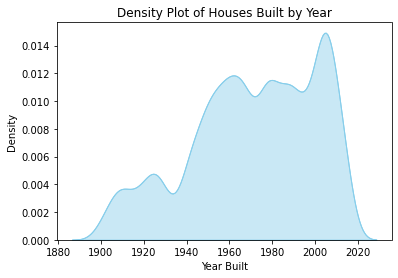

In [16]:
# Create a density plot of the year built
sns.kdeplot(df['yr_built'], shade=True, color='skyblue')

# Get the x and y values of the density plot
lines = sns.kdeplot(df['yr_built'], shade=True, color='skyblue').get_lines()
if lines:
    x, y = lines[0].get_data()
    plt.fill_between(x, y, color='skyblue', alpha=0.2)

# Set the title and axis labels
plt.title('Density Plot of Houses Built by Year')
plt.xlabel('Year Built')
plt.ylabel('Density')

# Display the density plot
plt.show()

There appears to be a higher concentration of houses that were built between 2000 to 2010. This can be observed through the histogram and density plot. 

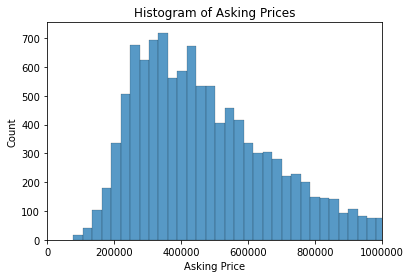

In [17]:
# Create a histogram of the asking prices
sns.histplot(df, x='asking_price')

# Set the title and axis labels
plt.title('Histogram of Asking Prices')
plt.xlabel('Asking Price')
plt.ylabel('Count')

# Set the x-axis limit to exclude higher home values
plt.xlim(0, 1000000)

# Format the tick labels on the x-axis
plt.ticklabel_format(style='plain', axis='x')

# Display the histogram
plt.show()

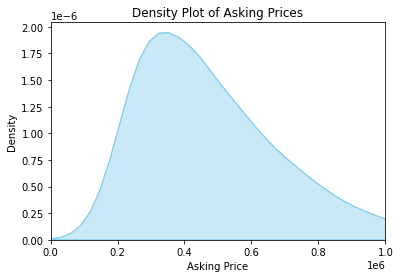

In [18]:
# Create a density plot of the asking prices
sns.kdeplot(df['asking_price'], shade=True, color='skyblue')

# Get the x and y values of the density plot
lines = sns.kdeplot(df['asking_price'], shade=True, color='skyblue').get_lines()
if lines:
    x, y = lines[0].get_data()
    plt.fill_between(x, y, color='skyblue', alpha=0.2)

# Set the title and axis labels
plt.title('Density Plot of Asking Prices')
plt.xlabel('Asking Price')
plt.ylabel('Density')

# Set the x-axis limit to exclude higher home values
plt.xlim(0, 1000000)

# Display the density plot
plt.show()

Based on the histogram and density plot, it appears that the majority of homes in the dataset were sold in the range of 300,000
to 400,000 dollars. This can be inferred from the peak in the distribution around this range, as well as the higher probability density values in the density plot. Seeing as this is a common price point for homes in this market, buyers and sellers may be more active in this range compared to other ranges.

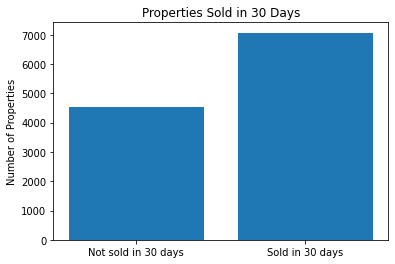

In [19]:
# Count the number of properties that sold in 30 days or less
sold_in_30_count = df['sold_in_30'].value_counts()

# Create a bar plot of the sold_in_30 column
fig, ax = plt.subplots()
ax.bar(sold_in_30_count.index, sold_in_30_count.values)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Not sold in 30 days', 'Sold in 30 days'])
ax.set_ylabel('Number of Properties')
ax.set_title('Properties Sold in 30 Days')
plt.show()

Although the target variable is not heavily imbalanced, it is worth noting that there are more properties in the dataset that were sold within 30 days than those that were not sold within 30 days. This information will be helpful to consider when building predictive models.

Moving forward, lets examine the columns in the dataset that are not of integer data type

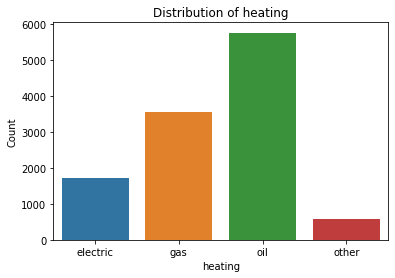

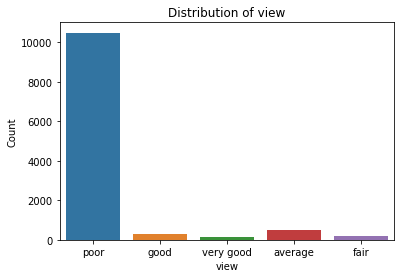

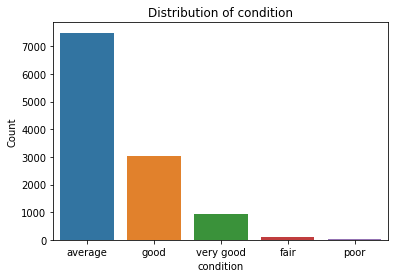

In [20]:
# select only object columns
object_cols = df.select_dtypes(include=['object']).columns.tolist()

# create bar plots for each object column
for col in object_cols:
    plt.figure()
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

Prior to training the model, we will need to perform one-hot encoding on the columns that are not of integer data type. To simplify the data and reduce dimensionality, we will also collapse the columns in the bottom two charts into two categories - low and high. This will help to reduce some of the noise in the data, as there are unique values that occur infrequently and are therefore less relevant to our analysis.

In [21]:
# replace "view" column values
map = {'poor': 'low', 'fair': 'low', 'average': 'low', 'good': 'high', 'very good': 'high'}

df['view'] = df['view'].replace(map)
df['condition'] = df['condition'].replace(map)

# print unique values and their counts for "view" column
view_counts = df['view'].value_counts()
view_counts_df = pd.DataFrame({'View': view_counts.index, 'Count': view_counts.values})

print('View Counts:\n', view_counts_df)

# Add a space between the print statements
print()

# print unique values and their counts for "condition" column
condition_counts = df['condition'].value_counts()
condition_counts_df = pd.DataFrame({'Condition': condition_counts.index, 'Count': condition_counts.values})

print('Condition Counts:\n', condition_counts_df)

View Counts:
    View  Count
0   low  11152
1  high    437

Condition Counts:
   Condition  Count
0       low   7609
1      high   3980


Moving forward, we will conduct an analysis of the correlation matrix. This will help identify which features have the strongest correlation with the target variable, as well as which features are highly correlated with each other. This information will be valuable in selecting the most informative features for building a predictive model, and will also help to identify potential issues with multicollinearity - where two or more features are highly correlated with each other, making it difficult to distinguish their individual effects on the target variable.

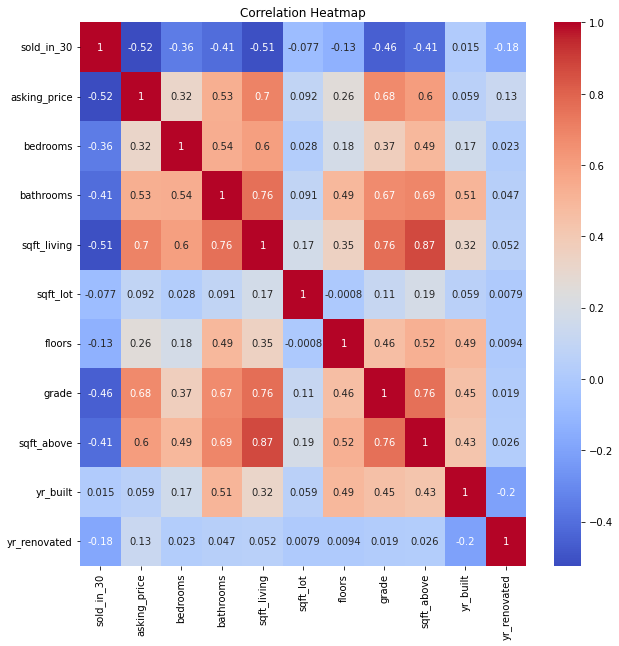

In [22]:
# Calculate the correlation matrix
corr = df.corr()

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, ax=ax)
ax.set_title("Correlation Heatmap")
plt.show()

Upon examining the correlation matrix, it was identified that there is a high correlation between two of the variables in the dataset - sqft_above and sqft_living. These variables have a correlation coefficient of greater than 0.8, indicating a strong positive relationship between them.

When two variables are highly correlated, it can create issues with multicollinearity and make it difficult to distinguish their individual effects on the target variable. Therefore, I have decided to drop one of these variables in order to simplify the model. **However, it's worth noting that neural networks are generally less prone to isssues related to multicollinearity compared to traditional statistical models.**

Given that sqft_living has a stronger correlation with the target variable than sqft_above, I decided to drop the sqft_above variable from the dataset. 

In [23]:
df = df.drop('sqft_above', axis=1)

In [24]:
# Inspect data again
df.head()

,sold_in_30,asking_price,bedrooms,bathrooms,heating,sqft_living,sqft_lot,floors,view,condition,grade,yr_built,yr_renovated
0,1,221900.0,3,1.00,electric,1180,5650,1.0,low,low,7,1955,0.0
1,0,538000.0,3,2.25,gas,2570,7242,2.0,low,low,7,1951,1991.0
2,0,510000.0,3,2.00,gas,1680,8080,1.0,low,low,8,1987,0.0
3,1,291850.0,3,1.50,gas,1060,9711,1.0,low,low,7,1963,0.0
4,1,468000.0,2,1.00,gas,1160,6000,1.0,low,high,7,1942,0.0


In [25]:
# Examine yr_renovated column
df['yr_renovated'].value_counts()

0.0       11208
2014.0       34
2013.0       19
2003.0       18
2007.0       17
          ...  
1948.0        1
1974.0        1
1963.0        1
1953.0        1
1972.0        1
Name: yr_renovated, Length: 65, dtype: int64

Upon examining the yr_renovated column, I noticed that a majority of the homes in the dataset did not have a value for this feature. While this could be a potential reason to drop the column from the dataset, I decided to keep it for now. This is because a renovation can have a significant impact on the price of a home and the likelihood of it being sold within 30 days. Therefore, this column could potentially be informative in building a predictive model.

Furthermore, there are still a few columns in the dataset that do not have numerical values, such as heating, view, and condition. Since these columns cannot be used in a neural net without first encoding them, I will use one-hot encoding to convert them into numerical features. This will incorporate these columns into the analysis and build a more accurate predictive model.

In [26]:
# Select columns to be one-hot encoded
cols_to_encode = ['heating', 'view', 'condition']

# One-hot encode the columns and append to the original DataFrame
df = pd.concat([df, pd.get_dummies(df[cols_to_encode], prefix=cols_to_encode)], axis=1)

# Drop the original columns that were encoded
df.drop(cols_to_encode, axis=1, inplace=True)

# Inspect df
df.head()

,sold_in_30,asking_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,yr_renovated,heating_electric,heating_gas,heating_oil,heating_other,view_high,view_low,condition_high,condition_low
0,1,221900.0,3,1.00,1180,5650,1.0,7,1955,0.0,1,0,0,0,0,1,0,1
1,0,538000.0,3,2.25,2570,7242,2.0,7,1951,1991.0,0,1,0,0,0,1,0,1
2,0,510000.0,3,2.00,1680,8080,1.0,8,1987,0.0,0,1,0,0,0,1,0,1
3,1,291850.0,3,1.50,1060,9711,1.0,7,1963,0.0,0,1,0,0,0,1,0,1
4,1,468000.0,2,1.00,1160,6000,1.0,7,1942,0.0,0,1,0,0,0,1,1,0


Before the train/test split, it is helpful to use Pearson's correlation coefficient to examine the correlation between the independent variables and the target variable. The next block of code does that and puts it in a table for easier viewing.

In [27]:
from prettytable import PrettyTable
from termcolor import colored
import re

# Calculate the Pearson correlation coefficient between each feature and the target variable
corr_matrix = df.corr()['sold_in_30'].drop('sold_in_30')

# Create a list to store the table data
table_data = []

# Add the results to the table data
for feature, corr in corr_matrix.iteritems():
    if corr > 0:
        color = 'green'
    elif corr < 0:
        color = 'red'
    else:
        color = 'white'
    table_data.append((colored(feature, color), colored(f"{corr:.3f}", color)))

# Sort the table data based on the correlation values
table_data_sorted = sorted(table_data, key=lambda x: float(re.sub('\x1b\[.*?m', '', x[1])), reverse=True)

# Create a table to display the results
table = PrettyTable()
table.title = colored('Target Variable Correlations', 'grey',attrs=['underline','bold'])
table.field_names = [colored('Feature', 'grey',attrs=['bold']), colored('Pearson Correlation', 'grey',attrs=['bold'])]
table.align['Feature'] = 'l'
table.align['Pearson Correlation'] = 'r'
table.float_format = ".3"

# Add the sorted results to the table
for row in table_data_sorted:
    table.add_row(row)

# Print the table with a centered title
print(table)

+------------------+---------------------+
|     Feature      | Pearson Correlation |
+------------------+---------------------+
|     view_low     |        0.241        |
|  condition_low   |        0.230        |
|   heating_oil    |        0.163        |
|  heating_other   |        0.019        |
|     yr_built     |        0.015        |
| heating_electric |        0.012        |
|     sqft_lot     |        -0.077       |
|      floors      |        -0.133       |
|   yr_renovated   |        -0.182       |
|   heating_gas    |        -0.196       |
|  condition_high  |        -0.230       |
|    view_high     |        -0.241       |
|     bedrooms     |        -0.356       |
|    bathrooms     |        -0.409       |
|      grade       |        -0.456       |
|   sqft_living    |        -0.508       |
|   asking_price   |        -0.524       |
+------------------+---------------------+


It doesn't appear that any of our features are highly correlated with the target variable, however, neural networks are designed to handle complex relationships between features and targets that are not easily detected by a simple correlation analysis. They can capture nonlinear relationships that a linear correlation analysis cannot.

## Train/Test Split and Feature Normalization

In [28]:
# Split into input and output variables. 
X = df.drop('sold_in_30', axis=1)
y = df['sold_in_30']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.head()

,asking_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,yr_built,yr_renovated,heating_electric,heating_gas,heating_oil,heating_other,view_high,view_low,condition_high,condition_low
2031,84000.0,2,1.00,700,20130,1.0,6,1949,0.0,0,0,1,0,0,1,0,1
9851,1270000.0,3,1.75,2240,5657,1.5,8,1941,0.0,0,0,1,0,0,1,1,0
7404,295000.0,4,2.25,1830,5720,2.0,7,2003,0.0,0,0,1,0,0,1,0,1
4575,450000.0,9,7.50,4050,6504,2.0,7,1996,0.0,0,0,1,0,0,1,0,1
4220,252500.0,4,2.50,2600,11280,1.5,7,1961,0.0,0,0,1,0,0,1,0,1


In [30]:
# Print the shapes of the training and test sets
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9271, 17)
y_train shape: (9271,)
X_test shape: (2318, 17)
y_test shape: (2318,)


In [31]:
# Checking Dtypes
X_train.dtypes

asking_price        float64
bedrooms              int64
bathrooms           float64
sqft_living           int64
sqft_lot              int64
floors              float64
grade                 int64
yr_built              int64
yr_renovated        float64
heating_electric      uint8
heating_gas           uint8
heating_oil           uint8
heating_other         uint8
view_high             uint8
view_low              uint8
condition_high        uint8
condition_low         uint8
dtype: object

Since the numerical columns have wide range of values, we need to scale those values to reduce the impact of outliers, ensure equal influence, and improve convergence.

In [32]:
# Select only the float and int dtypes columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print the names of the numerical columns
print(numerical_cols)

['asking_price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'yr_built', 'yr_renovated']


It's important to transform the training/test seperately because the scaling parameters (mean and std deviation) are calculated on the training data and then used to scale both the training and test data to prevent data leakage

In [33]:
# Use Z-Score standardization to standardize the numerical columns
col_transformer = ColumnTransformer([('scaled', StandardScaler(), numerical_cols)], 
                                    remainder='passthrough')

# Use col_transformer to fit/transform on training and then only transform on test
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

# Convert the training and test sets back to DFs so we can inspect them
X_train = pd.DataFrame(X_train, columns = col_transformer.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = col_transformer.get_feature_names_out())

# Inspect features_train
X_train.head()

,scaled__asking_price,scaled__bedrooms,scaled__bathrooms,scaled__sqft_living,scaled__sqft_lot,scaled__floors,scaled__grade,scaled__yr_built,scaled__yr_renovated,remainder__heating_electric,remainder__heating_gas,remainder__heating_oil,remainder__heating_other,remainder__view_high,remainder__view_low,remainder__condition_high,remainder__condition_low
0,-1.256720,-1.507181,-1.456044,-1.507329,0.114009,-0.905798,-1.406132,-0.749373,-0.183178,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,2.015654,-0.408410,-0.476247,0.178582,-0.230758,0.017528,0.297619,-1.021775,-0.183178,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.674535,0.690361,0.176950,-0.270264,-0.229257,0.940855,-0.554257,1.089339,-0.183178,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,-0.246864,6.184216,7.035524,2.160075,-0.210581,0.940855,-0.554257,0.850988,-0.183178,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,-0.791800,0.690361,0.503549,0.572692,-0.096810,0.017528,-0.554257,-0.340770,-0.183178,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [34]:
# Convert the standardized DataFrame back to numpy array
X_train = X_train.values
X_test = X_test.values

In [35]:
# Inspect first input
X_train[0]

array([-1.25671964, -1.50718055, -1.4560436 , -1.50732866,  0.11400876,
       -0.90579849, -1.40613215, -0.74937325, -0.18317784,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ])

Now that we have inspected the pandas dataframe and have converted those back to arrays, we are ready to proceed with training a neural network! 

## Model Development

Below is a homemade implementation of a neural network using sigmoid activation functions. The makeWeights function creates a matrix of randomly initialized weights between -1 and 1, and the NeuralNet class initializes the weights and biases for each layer of the network. The propagate function performs forward propagation through the network given an input and returns an array of the values of each node for each layer of the network. The findErrors function calculates the error at each node in the network given an actual output and a predicted output, and the findDeltas function calculates the change in weights and biases required to reduce the errors. The backpropagate function performs backpropagation through the network and updates the weights and biases. Finally, the predict function takes an input and returns the output of the neural network.

In [36]:
# Homemade Neural Network
random.seed(1)

def sigmoid(x):
    z = 1 / (1 + np.exp(-x))
    return z

# Creates a matrix of weights of a given size. All weights are randomly assigned a value between -1 and 1
def makeWeights(rows, cols):
    weights = []
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(random.uniform(-1, 1))
        weights.append(row)
    return weights

class NeuralNet:
    def __init__(self, inputSize, numLayers, sizeLayers):
                
        # The weights between the input layer and the first hidden layer
        self.weights = [makeWeights(sizeLayers, inputSize)]
         
        # The weights between the hidden layers
        for i in range(numLayers-1): 
            self.weights.append(makeWeights(sizeLayers, sizeLayers))
        
        # The weights between the last hidden layer and the output layer
        # This neural network implementation only has one output node
        last_weights = makeWeights(1, sizeLayers)
        self.weights.append(last_weights)
        
        # Creating the biases for each hidden layer
        self.biases = []
        for i in range(numLayers):
            layer = []
            for j in range(sizeLayers):
                layer.append([random.uniform(-1, 1)])
            self.biases.append(layer)
        
        # Adding the bias for the output layer
        self.biases.append([[random.uniform(-1, 1)]])
        
    def propagate(self, inputData):
        
        # Setting up our final result - an array containing the values of each node for each layer of the network.
        # The first layer is just the input layer
        layers = [[np.array(x) for x in inputData]]
        
        # The following layers are the dot product of the weights and the result of the previous layer (plus the bias)
        for i in range(0, len(self.weights)):
            nextLayer = [sigmoid(x) for x in np.dot(self.weights[i], layers[-1]) + self.biases[i]]
            layers.append(nextLayer)
        return layers
        
    def findErrors(self, result, actual):
        # The error for the output node is the actual answer minus the result
        errors = [actual - result]
        
        # We propogate the error to the previous layer by finding the correct weight matrix, transposing it, and taking the dot product of the error from the layer ahead
        for i in range(len(self.weights)):
            index = len(self.weights) - 1 - i
            transposedWeights = np.array(self.weights[index]).transpose()
            newErrors = np.dot(transposedWeights, errors[0])
            
            # Make sure to put the new error at the front of our errors array - we're building from the back of the network and adding each new error to the front
            errors.insert(0, newErrors)
        return errors
            
    def findDeltas(self, errors, layers, learning_rate):
        # Setting up our final result for the change in weights and bias
        delta_weights = []
        delta_bias = []
        for i in range(len(self.weights)):
            layers_index = len(self.weights) - i
            # Finding the output and error associated with the layer we're working with
            currentOutput = layers[layers_index]
            currentError = [np.array([x]) for x in errors[layers_index]]
            
            # Finding the transposed layer ahead of the layer we're currently working with
            next_layer = layers[layers_index - 1]
            next_layer_transposed = np.array(next_layer).transpose()
            
            # Finding the change in bias
            bias = np.array(learning_rate) * currentError * (currentOutput * (np.array(1) - currentOutput))
            delta_bias.insert(0, bias)
            
            # Finding the change in weights
            delta_weights.insert(0, np.dot(bias, next_layer_transposed))
        return delta_weights, delta_bias
            
        
    def backpropagate(self, inputValues, expected, learning_rate):
        # Propagating the data through the network and saving the results of each layer - to be used to find the deltas
        layers = self.propagate(inputValues)
        
        # Finding the output of the final layer - to be used to find the error of the final layer
        output = layers[-1][0]
        
        # Propagating the error back through the network
        errors = self.findErrors(output, expected)
        
        # Finding the changes in weights and biases based on the error, learning rate, and values stored in each neuron
        deltaWeights, delta_bias = self.findDeltas(errors, layers, learning_rate)
        
        # Applying the changes in the weights and biases
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] + deltaWeights[i]
        for i in range(len(self.biases)):
            self.biases[i] = self.biases[i] + delta_bias[i]
            
    def predict(self, inputValues):
        # Propagating the input through the neural net
        layers = self.propagate(inputValues)
        
        # Pulling out the output from the final layer and returning it
        output = layers[-1][0]
        return output

This is a very simple implementation of a neural network. The functionality is limited as it is only able to produce a single output which may not be sufficient for more complex problems. Additionally, it is only using the sigmoid function for the activation functions. This function has some limitations, such as the vanishing gradient problem. There are other activation functions such as ReLU that have been shown to be more effective (especially in the hidden layers). Finally, without modifying the NeuralNet Class, it is not possible to specify a different number of neurons per hidden layer (i.e.  32 neurons in the first hidden layer and 16 in the second).

If you wanted to change the model to output a continuous number instead of using sigmoid, you could modify the activation function of the output layer to a linear activation function which would allow the output to take on any continuous number instead of being restricted to values between 0 and 1.

In [37]:
# Create NeuralNet class instance w/ 17 inputs, 2 hidden layers, and 32 neurons
home_sold_nn = NeuralNet(17, 2, 32)

In [38]:
# Storing weights between the input and first hidden layer in variable
before_trng_weights = home_sold_nn.weights[0][0]
before_trng_weights

[-0.7312715117751976,
 0.6948674738744653,
 0.5275492379532281,
 -0.4898619485211566,
 -0.009129825816118098,
 -0.10101787042252375,
 0.3031859454455259,
 0.5774467022710263,
 -0.8122808264515302,
 -0.9433050469559874,
 0.6715302078397394,
 -0.13446586418989326,
 0.524560164915884,
 -0.9957878932977786,
 -0.10922561189039715,
 0.44308006468156513,
 -0.5424755574590947]

Note that the weights shown above are the initial values randomly assigned to the neural network. These weights will be updated during the training process, which involves backpropagation. By storing the initial weights in a variable, we can later compare them to the adjusted weights after the model has undergone training.

Homemade Neural Network Architecture


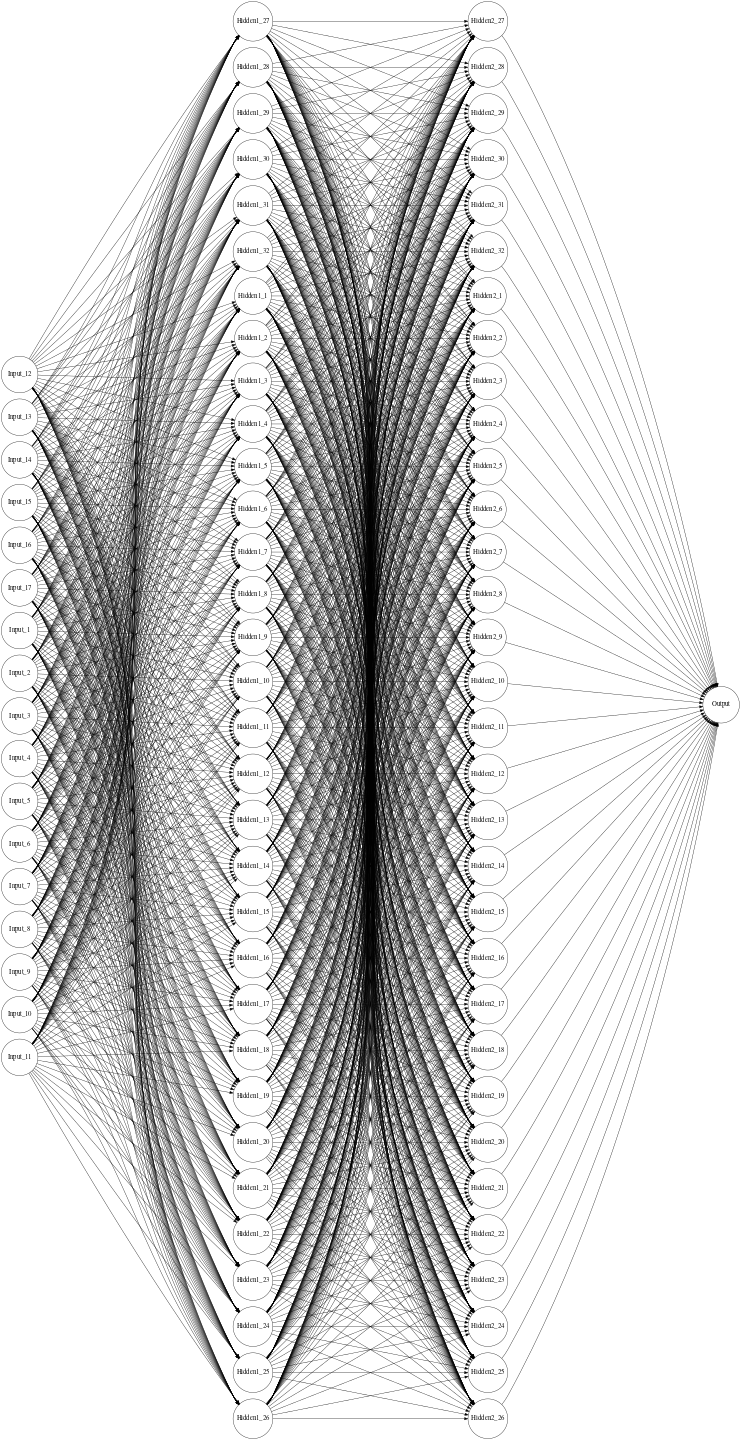

In [39]:
from IPython.display import display, Image
import graphviz

# Create the graph
graph = graphviz.Digraph(graph_attr={'size': '15,15', 'ranksep': '8',
                                     'rankdir':'LR'},
                         node_attr={'fixedsize':'false', 'width': '1.5', 
                                    'height':'1', 'fontsize':'20'})

# Add the input layer nodes
for i in range(17):
    graph.node(f'Input_{i+1}', shape='circle')

# Add the first hidden layer nodes
for i in range(32):
    graph.node(f'Hidden1_{i+1}', shape='circle')

# Add the second hidden layer nodes
for i in range(32):
    graph.node(f'Hidden2_{i+1}', shape='circle')

# Add the output layer node
graph.node('Output', shape='circle')

# Add the connections between the layers
for i in range(17):
    for j in range(32):
        graph.edge(f'Input_{i+1}', f'Hidden1_{j+1}')

for i in range(32):
    for j in range(32):
        graph.edge(f'Hidden1_{i+1}', f'Hidden2_{j+1}')

for i in range(32):
    graph.edge(f'Hidden2_{i+1}', 'Output')

# Render the graph and display it in the output
print("Homemade Neural Network Architecture")
display(Image(graph.render(format='png')))

This is an example of what this neural network architecture might look like. Here, it is shown that there is 17 inputs, 2 hidden layers, 32 neurons per layer and a single output layer.

The next step is to train the neural network using backpropagation. Backpropagation works by computing the difference between the predicted and actual outputs, and then adjusting the weights (and biases) accordingly by propagating this error back through the network. 

The code below takes training features from X_train and training labels from y_train. The learning rate is set to 0.1, and it iterates over X_train to adjust the weights and biases of the neural network based on the difference between predicted and actual outputs.

In [40]:
# Looping through each training data point
for i in range(len(X_train)):
    
    # Reformatting our training data to be a column rather than a row
    training_point = [[x] for x in X_train[i]]
    
    # Selecting the corresponding label for the training data point
    training_label = y_train.iloc[i]
    
    # Backpropagating error using training point / label / learning rate 0.1
    home_sold_nn.backpropagate(training_point, training_label, 0.1)

Now that the network has been trained, let's compare the initial weights to the weights that have been adjusted after backpropagation.

In [41]:
from tabulate import tabulate

# Convert the weights to lists of strings, swapping the order of the columns
weights_str = [[str(before_trng_weights[i]), str(w)] for i,
               w in enumerate(home_sold_nn.weights[0][0])]

# Title of chart
print('Initial Weight Values Between First Input Layer and First Hidden Layer Neuron')

# Print empty line
print()

# Print the table
print(tabulate(weights_str, headers=['Initial Random Training Weights', 
                                     'After Backpropagation Weights']))


Initial Weight Values Between First Input Layer and First Hidden Layer Neuron

  Initial Random Training Weights    After Backpropagation Weights
---------------------------------  -------------------------------
                      -0.731272                         -1.80782
                       0.694867                         -0.0812425
                       0.527549                          0.0516655
                      -0.489862                         -0.886155
                      -0.00912983                        0.221433
                      -0.101018                          0.0892325
                       0.303186                         -0.371874
                       0.577447                          0.794189
                      -0.812281                         -0.702188
                      -0.943305                         -0.842341
                       0.67153                          -0.398443
                      -0.134466                         -0.

As you can observe, the effect of backpropagation on these weights is substantial. This is not surprising considering that these weights were initially assigned at random. 

Next, let's generate predictions on both the training and test sets so that we can compare the results.

Below are the scores and confusion matrix for the training set:

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      3622
           1       0.87      0.92      0.89      5649

    accuracy                           0.87      9271
   macro avg       0.87      0.85      0.86      9271
weighted avg       0.87      0.87      0.87      9271



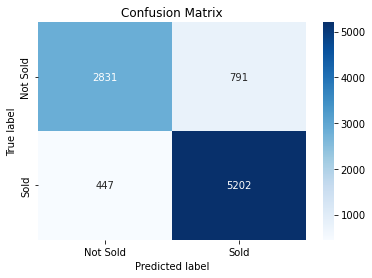

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions for the training data
train_predictions = []

# Loop through each train input
for i in range(len(X_train)):
    output = home_sold_nn.predict([[x] for x in X_train[i]])
    if output > 0.5:
        train_predictions.append(1)
    else:
        train_predictions.append(0)

print('Below are the scores and confusion matrix for the training set:')
print()
# Generate a classification report for the training data
print(classification_report(y_train, train_predictions))

# Generate a confusion matrix for the training data using seaborn
cm = confusion_matrix(y_train, train_predictions)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Not Sold", "Sold"], yticklabels=["Not Sold", "Sold"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

Below are the scores and confusion matrix for the test set:

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       899
           1       0.86      0.92      0.89      1419

    accuracy                           0.86      2318
   macro avg       0.86      0.84      0.85      2318
weighted avg       0.86      0.86      0.86      2318



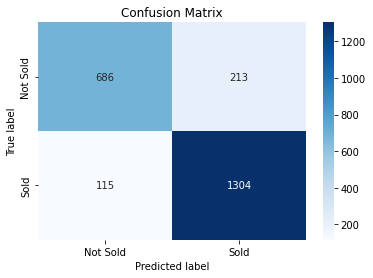

In [43]:
# Generate predictions for the testing data
test_predictions = []

# Loop through each test input
for i in range(len(X_test)):
    # Make prediction for current input by passing it through the neural net
    output = home_sold_nn.predict([[x] for x in X_test[i]])
    
    # If output greater than .5 assume house sold, otherwise append 0 (notsold)
    if output > 0.5:
        test_predictions.append(1)
    else:
        test_predictions.append(0)

print('Below are the scores and confusion matrix for the test set:')
print()

# Generate a classification report for the training data
print(classification_report(y_test, test_predictions))

# Generate a confusion matrix for the training data using seaborn
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Not Sold", "Sold"], yticklabels=["Not Sold", "Sold"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

Now, we will make a table and include accuracy for an easy side by side comparison

In [44]:
from sklearn.metrics import accuracy_score

# Generate classification reports for training and testing data
train_report = classification_report(y_train, train_predictions, 
                                     output_dict=True)
test_report = classification_report(y_test, test_predictions, 
                                    output_dict=True)

# Extract the scores
scores = ['accuracy', 'precision', 'recall', 'f1-score', 'support']
train_scores = [accuracy_score(y_train, train_predictions)]
train_scores += [train_report['weighted avg'][score] for score in scores[1:]]
test_scores = [accuracy_score(y_test, test_predictions)]
test_scores += [test_report['weighted avg'][score] for score in scores[1:]]

# Create the DataFrame
score_df = pd.DataFrame({'Training': train_scores,
                   'Testing': test_scores
                    }, index=scores)

score_df = score_df.transpose()

# Display the DataFrame
print(score_df)

          accuracy  precision    recall  f1-score  support
Training  0.866465   0.866303  0.866465  0.865109   9271.0
Testing   0.858499   0.858365  0.858499  0.856782   2318.0


Since the accuracy on the training and test sets are very close, it typically suggests that the model is generalizing well to new, unseen data. This is because the model has learned to make accurate predictions not only on the data it was trained on (i.e., the training set) but also on new data that it has not seen before (i.e., the test set). The training and testing accuracies are 0.87 and 0.86 respectively. These values indicate that the model is performing reasonably well, but there is still room for improvement.

Additionally, by examining the individual confusion matrixes for the training and test predictions, the scores indicated that the model is identifying a high proportion of the homes that sold witin 30 days.

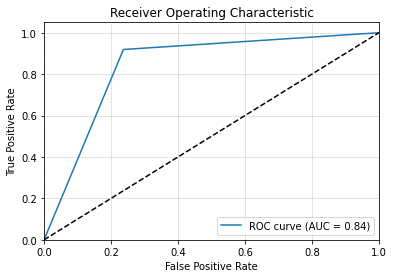

In [45]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and thresholds for the predictions
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

The "elbow" in the ROC curve refers to the point where the curve starts to level off and become more horizontal. The elbow point on the ROC curve can be used to determine the optimal threshold for a binary classification problem (in this case, whether or not the home sold in 30 days). 

The point on the curve that maximizes the trade-off between true positive rate (TPR) and false positive rate (FPR) might be the optimal threshold. Depending on the specific use case, there may be instances where one would want to prioritize maximizing either the TPR or FPR. Experimentation with adjusting the prediction loops that were used to make the predictions can help explore these scenarios, but such exploration falls outside the scope of this assignment.